In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.optimizers import SGD
import h5py


## dirs

In [2]:
train_dir = "D:/code/Dog breed classification/train"
test_dir = "D:/code/Dog breed classification/test"

## jpg

Open file with labels and add ".jpg" to filenames

In [3]:
labels = pd.read_csv("D:/code/Dog breed classification/labels.csv")

In [4]:
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [5]:
new_id = [el +".jpg" for el in labels["id"]]
labels["id"] = new_id

## ImageDataGenerator

customization of generator

In [6]:
generator = ImageDataGenerator(
    validation_split=0.02,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)


BATCH_SIZE = 32
image_size=(331,331)

## flow_from_dataframe

load photo/images from dataframe

In [7]:
train_generator = generator.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir,
    x_col="id",
    y_col="breed",
    target_size=image_size,
    batch_size=32,
    subset="training",
)

valid_generator = generator.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir,
    x_col="id",
    y_col="breed",
    target_size=image_size,
    batch_size=32,
    subset="validation",
)

Found 10018 validated image filenames belonging to 120 classes.
Found 204 validated image filenames belonging to 120 classes.


## NASNetLarge

In [3]:
nas_model=NASNetLarge(
    include_top=False, 
    weights='imagenet', 
    input_shape=(331,331,3),
)

nas_model.trainable = False
    
model = tensorflow.keras.Sequential(
    [
        nas_model,   
        layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(120, activation='softmax')
    ]
)



In [6]:
print(nas_model.summary())

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

separable_conv_2_normal_right2_ (None, 21, 21, 336)  115920      activation_137[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_left5_9 (None, 21, 21, 336)  115920      activation_139[0][0]             
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 21, 21, 336)  1344        separable_conv_2_normal_left1_9[0
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 21, 21, 336)  1344        separable_conv_2_normal_right1_9[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 21, 21, 336)  1344        separable_conv_2_normal_left2_9[0
__________________________________________________________________________________________________
separable_

## Compile and Train
customization of model for getting weights and fiting it

In [4]:
opt = SGD(lr=1e-3, momentum=0.9)
model.compile(
    optimizer = opt, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)
model.summary()
NASNetLarge.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               483960    
Total params: 85,400,778
Trainable params: 483,960
Non-trainable params: 84,916,818
_________________________________________________________________


AttributeError: 'function' object has no attribute 'summary'

In [10]:
early = tensorflow.keras.callbacks.EarlyStopping(
    patience=2, 
    min_delta=0.001, 
    restore_best_weights=True
)

In [11]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit(
    train_generator, 
    steps_per_epoch=STEP_SIZE_TRAIN, 
    validation_data=valid_generator, 
    validation_steps=STEP_SIZE_VALID, 
    epochs=25,
    verbose = 1,
    batch_size=32, 
    callbacks=[early], 
)

Epoch 1/25
313/313 [==============================] - 1090s 3s/step - loss: 3.8467 - accuracy: 0.5868 - val_loss: 2.9746 - val_accuracy: 0.8542
Epoch 2/25
313/313 [==============================] - 2519s 8s/step - loss: 2.0971 - accuracy: 0.9154 - val_loss: 1.6057 - val_accuracy: 0.8854
Epoch 3/25
313/313 [==============================] - 759s 2s/step - loss: 1.1127 - accuracy: 0.9302 - val_loss: 0.9378 - val_accuracy: 0.8958
Epoch 4/25
313/313 [==============================] - 815s 3s/step - loss: 0.6948 - accuracy: 0.9369 - val_loss: 0.6602 - val_accuracy: 0.9271
Epoch 5/25
313/313 [==============================] - 1143s 4s/step - loss: 0.5113 - accuracy: 0.9383 - val_loss: 0.4914 - val_accuracy: 0.9375
Epoch 6/25
313/313 [==============================] - 1891s 6s/step - loss: 0.4163 - accuracy: 0.9398 - val_loss: 0.4488 - val_accuracy: 0.9271
Epoch 7/25
313/313 [==============================] - 897s 3s/step - loss: 0.3619 - accuracy: 0.9421 - val_loss: 0.3839 - val_accuracy: 0.

## Test Datagen

In [14]:
test_df = pd.read_csv("D:/code/Dog breed classification/sample_submission.csv")

In [15]:
new_id = [el +".jpg" for el in test_df["id"]]
test_df["id"] = new_id

In [16]:
test_datagen=ImageDataGenerator(
    preprocessing_function = preprocess_input,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="id",
    y_col=None,
    target_size=image_size,
    batch_size=32,
    class_mode=None,
    shuffle=False,
    
)

Found 10357 validated image filenames.


## prediction

In [17]:
y_pred = model.predict(test_generator)

In [18]:
y_pred

array([[1.9420314e-04, 1.8011972e-04, 1.3777909e-04, ..., 1.4319779e-04,
        2.6141043e-04, 1.5877964e-04],
       [1.3435048e-04, 4.8170485e-05, 7.9013051e-05, ..., 1.7181346e-04,
        1.0544596e-04, 2.3303626e-04],
       [1.4121480e-04, 6.5404538e-04, 2.5924749e-04, ..., 1.7618970e-04,
        1.5039362e-04, 1.4349265e-04],
       ...,
       [2.0318550e-04, 2.2292526e-04, 5.0461944e-03, ..., 3.1298574e-04,
        3.4819118e-04, 2.1579103e-04],
       [4.9352902e-04, 1.4314722e-04, 2.7343101e-04, ..., 4.2318981e-04,
        1.3997544e-04, 5.1208847e-04],
       [9.5771247e-05, 4.6944458e-04, 3.1776418e-04, ..., 1.7797736e-03,
        2.8255698e-04, 1.2335740e-04]], dtype=float32)

In [19]:
model.save("my_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model\assets


In [2]:
model = tensorflow.keras.models.load_model('my_model')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               483960    
Total params: 85,400,778
Trainable params: 85,204,110
Non-trainable params: 196,668
_________________________________________________________________


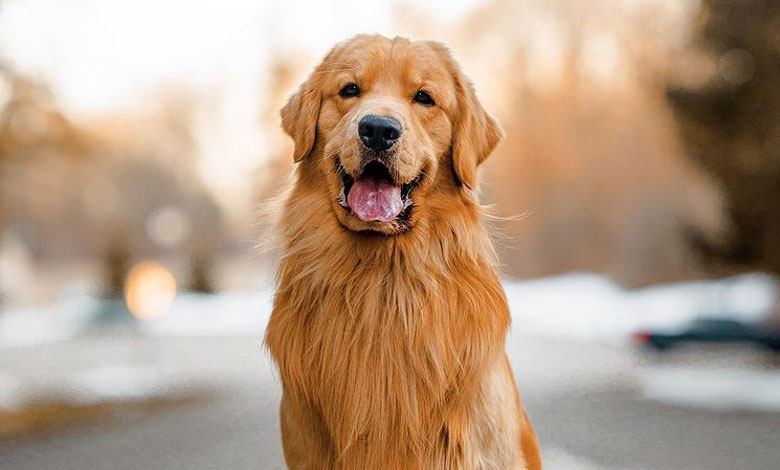

In [5]:
from PIL import Image

img = Image.open('tucker.jpg')
img

In [6]:
BATCH_SIZE = 32
image_size=(331,331)

test_datagen=ImageDataGenerator(
    preprocessing_function = preprocess_input,
)

test_generator = test_datagen.flow_from_directory(
    directory='D:/code/Dog breed classification/noob',
    target_size=image_size,
    batch_size=32,
    class_mode=None,
    shuffle=False,
    
)

Found 1 images belonging to 1 classes.


In [7]:
pred = model.predict(test_generator)
pred

array([[4.0632434e-04, 3.0011268e-04, 2.3660084e-04, 2.5999150e-04,
        4.7477699e-04, 1.0063709e-03, 1.1179541e-03, 3.7289885e-04,
        3.6014154e-04, 5.4227596e-04, 2.0450610e-04, 1.0943683e-03,
        7.6822023e-04, 1.7418586e-04, 4.1340728e-04, 2.6008376e-04,
        1.0116722e-03, 5.6768552e-04, 2.9970880e-04, 3.9582205e-04,
        1.8153327e-04, 6.6853315e-04, 3.4915871e-04, 4.5507640e-04,
        9.2750811e-04, 5.8355252e-04, 6.7057746e-04, 1.0683343e-03,
        5.9682591e-04, 2.9634111e-04, 5.9474353e-04, 1.2757848e-03,
        5.2413053e-04, 2.5872549e-03, 6.6242157e-04, 4.3128751e-04,
        4.3595023e-04, 5.4156996e-04, 2.0288887e-04, 4.7949568e-04,
        4.3504586e-04, 3.6387215e-04, 6.1458343e-04, 5.2557961e-04,
        4.0527848e-03, 2.8570226e-04, 6.6320220e-04, 2.2737152e-04,
        3.2466304e-04, 9.1021281e-01, 1.3058460e-03, 4.8529563e-04,
        6.1160917e-03, 7.1033108e-04, 3.2401056e-04, 3.0054455e-04,
        2.0843523e-03, 6.3694798e-04, 3.6082327e

In [8]:
y = np.argmax(pred)

In [9]:
labels = pd.read_csv("D:/code/Dog breed classification/dogs_breed.csv")

In [10]:
print("The breed of the dog is : ",labels.loc[y].at['breed'])

The breed of the dog is :  golden_retriever
